### Preprocessing

In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt


data = pd.read_csv('game_data.csv')
data.head()

,timer,has_round_started,is_round_over,player1_ID,player1_health,player2_ID,player2_health,player1_x_coord,player1_y_coord,player2_x_coord,...,player2_down,player2_jump,player2_crouch,player2_A,player2_B,player2_X,player2_Y,player2_L,player2_R,fight_result
0,153,False,False,0,176,6,176,205,192,307,...,True,False,False,True,False,True,False,True,False,NOT_OVER
1,153,False,False,0,176,6,176,205,192,307,...,True,False,False,False,False,True,False,True,True,NOT_OVER
2,153,False,False,0,176,6,176,205,192,307,...,True,False,False,True,False,False,False,True,True,NOT_OVER
3,153,False,False,0,176,6,176,205,192,307,...,False,False,False,True,False,True,False,True,True,NOT_OVER
4,153,False,False,0,176,6,176,205,192,307,...,False,False,False,True,True,False,True,True,True,NOT_OVER


In [18]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [19]:
numeric_imputer = SimpleImputer(strategy='median')
data[numerical_columns] = numeric_imputer.fit_transform(data[numerical_columns])

In [20]:
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

In [21]:
data['fight_result'] = LabelEncoder().fit_transform(data['fight_result'])

In [22]:
target_columns = [
    'player1_left', 'player1_right', 'player1_up', 'player1_down', 'player1_A', 'player1_B', 'player1_X', 'player1_Y', 'player1_L', 'player1_R',
    'player2_left', 'player2_right', 'player2_up', 'player2_down', 'player2_A', 'player2_B', 'player2_X', 'player2_Y', 'player2_L', 'player2_R'
]

In [23]:
X = data.drop(columns=target_columns + ['fight_result'])
y = data[target_columns].map(lambda v: 1 if v else 0)
y.head()

,player1_left,player1_right,player1_up,player1_down,player1_A,player1_B,player1_X,player1_Y,player1_L,player1_R,player2_left,player2_right,player2_up,player2_down,player2_A,player2_B,player2_X,player2_Y,player2_L,player2_R
0,1,1,0,1,1,1,1,1,0,0,1,0,0,1,1,0,1,0,1,0
1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,1,0,1,1
2,1,0,0,1,1,0,0,0,1,1,1,1,0,1,1,0,0,0,1,1
3,1,1,1,1,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,1
4,0,0,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,1,1


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Training 

In [26]:
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

multi_mlp = MultiOutputClassifier(mlp, n_jobs=-1)
multi_mlp.fit(X_train_scaled, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                              max_iter=300, random_state=42),
                      n_jobs=-1)

In [27]:
y_pred = pd.DataFrame(
    multi_mlp.predict(X_test_scaled),
    columns=target_columns
)

y_pred.head()

,player1_left,player1_right,player1_up,player1_down,player1_A,player1_B,player1_X,player1_Y,player1_L,player1_R,player2_left,player2_right,player2_up,player2_down,player2_A,player2_B,player2_X,player2_Y,player2_L,player2_R
0,1,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,1,0,1,0
1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0
2,1,1,0,0,1,1,1,0,1,0,0,0,1,1,1,0,1,0,1,0
3,0,0,0,1,1,0,1,0,1,1,0,1,0,0,1,0,1,1,1,0
4,0,0,0,1,1,1,1,1,1,0,0,0,0,0,1,0,1,1,1,0


In [28]:
accuracy = (y_pred.values == y_test.values).mean()
print(f"Multi-Output MLP overall accuracy: {accuracy:.4f}")

Multi-Output MLP overall accuracy: 0.6066


In [29]:
joblib.dump(multi_mlp, 'best_mlp_bot_model.pkl')
scaler = StandardScaler().fit(X_train)
joblib.dump(scaler, 'scaler.pkl')
print("Saved: best_mlp_bot_model.pkl and scaler.pkl")

Saved: best_mlp_bot_model.pkl and scaler.pkl


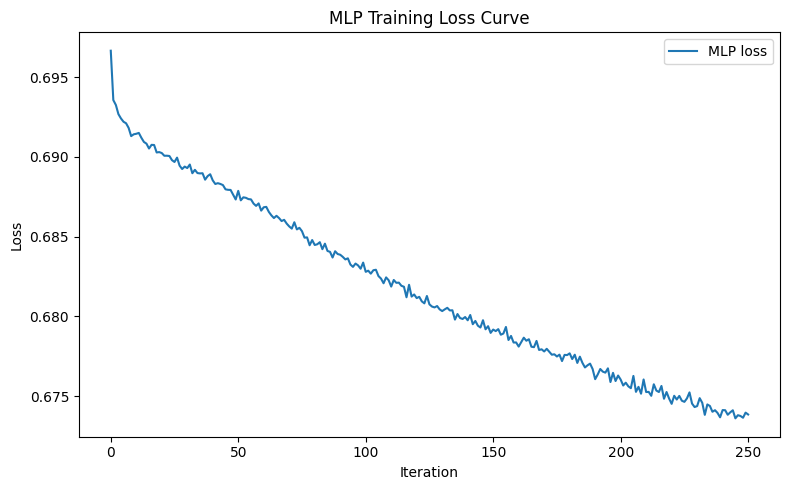

In [30]:
plt.figure(figsize=(8,5))
plt.plot(multi_mlp.estimators_[0].loss_curve_, label='MLP loss')
plt.title("MLP Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
X_train

,timer,has_round_started,is_round_over,player1_ID,player1_health,player2_ID,player2_health,player1_x_coord,player1_y_coord,player2_x_coord,player2_y_coord,player1_jump,player1_crouch,player2_jump,player2_crouch
9902,97.0,True,False,1.0,135.0,2.0,108.0,195.0,192.0,361.0,100.0,False,False,True,False
19471,118.0,True,False,11.0,34.0,6.0,142.0,55.0,192.0,130.0,192.0,False,False,False,False
27641,130.0,True,False,6.0,121.0,6.0,52.0,70.0,169.0,211.0,192.0,False,False,False,False
19671,113.0,True,False,11.0,34.0,6.0,137.0,58.0,132.0,116.0,192.0,False,False,False,False
13620,150.0,True,False,3.0,140.0,6.0,170.0,164.0,169.0,266.0,192.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,146.0,True,False,10.0,113.0,6.0,170.0,106.0,192.0,167.0,192.0,False,False,False,False
6265,49.0,True,False,0.0,83.0,7.0,60.0,369.0,192.0,453.0,157.0,False,False,False,False
11284,32.0,True,False,1.0,135.0,2.0,3.0,218.0,192.0,346.0,192.0,False,False,False,False
860,119.0,True,False,0.0,176.0,6.0,53.0,304.0,192.0,388.0,192.0,False,False,False,False
